# Post Processing

This notebook demonstrates a full **post-processing pipeline** for point clouds, generating structured statistics and visualizations.

---

## Pipeline Overview

The workflow is divided into **11 main steps**:

1. **Extract archives** → Uncompress all submissions from `raw_dir` to `extracted_dir`.
2. **Analyze submission directory** → Scan `extracted_dir` to collect mandatory files:
   - `*_dense_pointcloud.las/laz`
   - `*_sparse_pointcloud.las/laz`
   - `*_extrinsics.csv`
   - `*_intrinsics.csv`
3. **Create point cloud symlinks** → Organize dense point cloud files by `(site, dataset)` using symbolic links in `processing_dir`.
4. **Convert point clouds to DEMs** → Generate DEMs from point clouds via PDAL; skip existing DEMs unless `overwrite=True`.
5. **Coregister DEMs** → Align all DEMs to their reference DEMs; skip existing coregistered DEMs if `overwrite=False`.
6. **Generate differential DEMs (DDEMs)** → Compute `ddem_before` and `ddem_after` for each DEM relative to the reference.
7. **Compute statistics** → Compute global statistics, coregistration shifts, point cloud metadata, and apply NMAD-based inliers filtering.
8. **Compute landcover-based statistics** → Stratify statistics for coregistered DEMs by reference landcover.
9. **Generate standard deviation DEMs (std DEMs)** → Compute std DEMs for raw and coregistered DEMs; process both all and inliers-only sets.
10. **Compute landcover statistics on std DEMs** → Stratify std DEM statistics by landcover and save results.
11. **Generate post-processing plots** → Create comprehensive visual summaries including:
    - Global and per-dataset summaries
    - DEM quality metrics and NMAD before/after coregistration
    - Coregistration shifts and landcover-based statistics
    - Slope and hillshade mosaics


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import history.postprocessing as pp
from prefect.task_runners import ConcurrentTaskRunner
from prefect.logging import get_logger
import logging

/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## ⚙️ Settings and Path Management

Main directories used in the post-processing pipeline:

- **`raw_dir`** → Contains all raw input archives.  
- **`extracted_dir`** → Stores extracted archives.  
- **`processing_dir`** → Main workspace for intermediate and processed data.  
- **`plots_dir`** → Output folder for generated plots and visualizations.

> 💡 These directories are automatically created when running the Prefect flows.


In [3]:
# paths
raw_dir = "/mnt/summer/USERS/DEHECQA/history/output/raw"
extracted_dir = "/mnt/summer/USERS/DEHECQA/history/output/extracted"
processing_dir = "/mnt/summer/USERS/DEHECQA/history/output/processing" 
plots_dir = "/mnt/summer/USERS/DEHECQA/history/output/plots" 

# other settings
OVERWRITE = False
DRY_RUN = False # set this to True to avoid process
PDAL_EXEC_PATH = "/home/godinlu/micromamba/envs/pdal/bin/pdal"

# Change global Prefect logging level
prefect_logger = get_logger()
prefect_logger.setLevel(logging.WARNING)

### 🧩 Step 1 — Uncompress All Submissions

This step extracts all supported archive submissions from the `raw_dir` into the `extracted_dir`.  
The flow `uncompress_all_submissions` scans the input directory for archives (`.zip`, `.7z`, `.tgz`, `.tar.gz`, `.tar.bz2`, `.tar.xz`) and extracts each one into a corresponding folder in the output directory.

Extraction tasks run in parallel via Prefect, and existing folders are skipped unless `overwrite=True` is specified.  
Each archive produces one folder in `extracted_dir` containing the uncompressed contents of that submission.


In [6]:
task_runner = ConcurrentTaskRunner(max_workers=4)
pp.uncompress_all_submissions.with_options(task_runner=task_runner)(raw_dir, extracted_dir, OVERWRITE)

### 🧩 Step 2 — Analyze Submission Directory

In this step, the flow `analyze_submission_dir` scans the `extracted_dir` to collect and organize all relevant submission files.  
For each submission folder, it searches recursively for mandatory files:

- `*_dense_pointcloud.las` / `*_dense_pointcloud.laz`
- `*_sparse_pointcloud.las` / `*_sparse_pointcloud.laz`
- `*_extrinsics.csv`
- `*_intrinsics.csv`

The flow parses each filename to extract metadata (e.g., site, dataset, code) and creates a structured `DataFrame` indexed by `code`.  
Each row contains the paths to the found files and associated metadata.  
Warnings are logged for any submission missing one or more mandatory files.


In [7]:
df = pp.batch.analyze_submission_dir(extracted_dir)

09:41:39.934 | WARNING | Flow run 'laughing-jaguar' - KritiAtanuTobias_CG_MC_RA_CY_GN_PN_MN_v1 - Missing the following mandatory file(s) : ['sparse_pointcloud_file', 'extrinsics_file', 'intrinsics_file']

09:41:39.945 | WARNING | Flow run 'laughing-jaguar' - AtanuKritiTobias_CG_MC_RA_CY_GY_PN_MN_v1 - Missing the following mandatory file(s) : ['sparse_pointcloud_file', 'extrinsics_file', 'intrinsics_file']

09:41:39.948 | WARNING | Flow run 'laughing-jaguar' - AdinaR_CG_MC_PP_CY_GY_PN_MN - Missing the following mandatory file(s) : ['dense_pointcloud_file', 'sparse_pointcloud_file']

09:41:39.951 | WARNING | Flow run 'laughing-jaguar' - hai-sfm_CG_AI_PP_CY_GN_PN_MN - Missing the following mandatory file(s) : ['dense_pointcloud_file']

09:41:39.955 | WARNING | Flow run 'laughing-jaguar' - hai-sfm_CG_AI_PP_CY_GN_PN_MN_v1 - Missing the following mandatory file(s) : ['sparse_pointcloud_file', 'extrinsics_file', 'intrinsics_file']

09:41:39.957 | WARNING | Flow run 'laughing-jaguar' - hai-sfm_CG_AI_PP_CY_GN_PN_MN_v2 - Missing the following mandatory file(s) : ['sparse_pointcloud_file', 'extrinsics_file', 'intrinsics_file']

### 🧩 Step 3 — Create Point Cloud Symlinks

This step organizes the collected dense point cloud files by creating **symbolic links** in the `processing_dir`.  

The function `create_pointcloud_symlinks` takes a list of dense point cloud paths and, for each file:

- Extracts metadata (site and dataset) from the filename using `parse_filename`.
- Groups files by `(site, dataset)`.
- Creates symbolic links under the following directory hierarchy:



In [8]:
pointcloud_files = df["dense_pointcloud_file"].dropna().to_list()
pp.create_pointcloud_symlinks(pointcloud_files, processing_dir)

 casa_grande - aerial → 18 pointcloud(s) linked.
 casa_grande - kh9mc → 6 pointcloud(s) linked.
 casa_grande - kh9pc → 1 pointcloud(s) linked.
 iceland - aerial → 9 pointcloud(s) linked.
 iceland - kh9mc → 4 pointcloud(s) linked.
 iceland - kh9pc → 0 pointcloud(s) linked.


### 🧩 Step 4 — Convert Point Clouds to DEMs

In this step, the flow `process_pointclouds_to_dems` converts all point clouds in the `processing_dir` into **Digital Elevation Models (DEMs)** for each site and dataset.

For each subdirectory, the flow:

- Retrieves the reference DEM for the dataset.
- Converts each point cloud into a DEM using the **PDAL** pipeline.
- Skips conversion if the DEM already exists and `overwrite=False`.
- Executes tasks asynchronously via Prefect, allowing parallel processing.
- Logs any errors encountered per file or dataset without stopping the overall execution.

All generated DEMs are saved under their corresponding site and dataset subdirectories in `processing_dir`.  
The `dry_run` option can be used to simulate the execution without creating any files.


In [4]:
task_runner = ConcurrentTaskRunner(max_workers=4)
pp.batch.process_pointclouds_to_dems.with_options(task_runner=task_runner)(processing_dir, PDAL_EXEC_PATH, OVERWRITE, DRY_RUN)

13:53:15.436 | ERROR   | Task run 'point2dem_hai-sfm_CG_AI_PP_CY_GN_PN_MN_v1-8ab' - Task run failed with exception: ValueError("hai-sfm_CG_AI_PP_CY_GN_PN_MN_v1_dense_pointcloud.las : Can't find a valid CRS")
Traceback (most recent call last):
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/prefect/task_engine.py", line 872, in run_context
    yield self
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/prefect/task_engine.py", line 1514, in run_task_sync
    engine.call_task_fn(txn)
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/prefect/task_engine.py", line 889, in call_task_fn
    result = call_with_parameters(self.task.fn, parameters)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/prefect/utilities/callables.py", line 210, in call_with_parameters
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/home/godinlu/github/history/src/history/postprocessing/core.py", line 284, in convert_pointcloud_to_dem
    raise ValueError(f"{pointcloud_path.name} : Can't find a valid CRS")
ValueError: hai-sfm_CG_AI_PP_CY_GN_PN_MN_v1_dense_pointcloud.las : Can't find a valid CRS

13:53:15.469 | ERROR   | Task run 'point2dem_hai-sfm_CG_AI_PP_CY_GN_PN_MN_v1-8ab' - Finished in state Failed("Task run encountered an exception ValueError: hai-sfm_CG_AI_PP_CY_GN_PN_MN_v1_dense_pointcloud.las : Can't find a valid CRS")

13:53:15.493 | ERROR   | Flow run 'platinum-civet' - Point2dem error for hai-sfm_CG_AI_PP_CY_GN_PN_MN_v1: hai-sfm_CG_AI_PP_CY_GN_PN_MN_v1_dense_pointcloud.las : Can't find a valid CRS

13:53:33.040 | ERROR   | Task run 'point2dem_hai-sfm_IL_AI_PP_CY_GN_PN_MN-4b3' - Task run failed with exception: ValueError("hai-sfm_IL_AI_PP_CY_GN_PN_MN_dense_pointcloud.las : Can't find a valid CRS")
Traceback (most recent call last):
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/prefect/task_engine.py", line 872, in run_context
    yield self
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/prefect/task_engine.py", line 1514, in run_task_sync
    engine.call_task_fn(txn)
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/prefect/task_engine.py", line 889, in call_task_fn
    result = call_with_parameters(self.task.fn, parameters)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/prefect/utilities/callables.py", line 210, in call_with_parameters
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/home/godinlu/github/history/src/history/postprocessing/core.py", line 284, in convert_pointcloud_to_dem
    raise ValueError(f"{pointcloud_path.name} : Can't find a valid CRS")
ValueError: hai-sfm_IL_AI_PP_CY_GN_PN_MN_dense_pointcloud.las : Can't find a valid CRS

13:53:33.049 | ERROR   | Task run 'point2dem_hai-sfm_IL_AI_PP_CY_GN_PN_MN-4b3' - Finished in state Failed("Task run encountered an exception ValueError: hai-sfm_IL_AI_PP_CY_GN_PN_MN_dense_pointcloud.las : Can't find a valid CRS")

13:53:44.329 | ERROR   | Task run 'point2dem_hai-sfm_CG_AI_PP_CY_GN_PN_MN_v2-042' - Task run failed with exception: ValueError("hai-sfm_CG_AI_PP_CY_GN_PN_MN_v2_dense_pointcloud.las : Can't find a valid CRS")
Traceback (most recent call last):
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/prefect/task_engine.py", line 872, in run_context
    yield self
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/prefect/task_engine.py", line 1514, in run_task_sync
    engine.call_task_fn(txn)
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/prefect/task_engine.py", line 889, in call_task_fn
    result = call_with_parameters(self.task.fn, parameters)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/prefect/utilities/callables.py", line 210, in call_with_parameters
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/home/godinlu/github/history/src/history/postprocessing/core.py", line 284, in convert_pointcloud_to_dem
    raise ValueError(f"{pointcloud_path.name} : Can't find a valid CRS")
ValueError: hai-sfm_CG_AI_PP_CY_GN_PN_MN_v2_dense_pointcloud.las : Can't find a valid CRS

13:53:44.345 | ERROR   | Task run 'point2dem_hai-sfm_CG_AI_PP_CY_GN_PN_MN_v2-042' - Finished in state Failed("Task run encountered an exception ValueError: hai-sfm_CG_AI_PP_CY_GN_PN_MN_v2_dense_pointcloud.las : Can't find a valid CRS")

13:53:44.351 | ERROR   | Flow run 'platinum-civet' - Point2dem error for hai-sfm_CG_AI_PP_CY_GN_PN_MN_v2: hai-sfm_CG_AI_PP_CY_GN_PN_MN_v2_dense_pointcloud.las : Can't find a valid CRS

13:56:51.771 | ERROR   | Flow run 'platinum-civet' - Point2dem error for hai-sfm_IL_AI_PP_CY_GN_PN_MN: hai-sfm_IL_AI_PP_CY_GN_PN_MN_dense_pointcloud.las : Can't find a valid CRS

### 🧩 Step 5 — Coregister DEMs

This step aligns all generated DEMs in the `processing_dir` to their corresponding **reference DEMs**.

The flow `process_coregister_dems` performs the following for each site and dataset:

- Retrieves the reference DEM and its mask.
- Aligns all raw DEMs to the reference using the coregistration pipeline.
- Skips DEMs that are already coregistered if `overwrite=False`.
- Submits each coregistration task asynchronously via Prefect for parallel execution.
- Logs any errors for individual DEMs or datasets without stopping the overall workflow.

All coregistered DEMs are saved under their respective site and dataset subdirectories in `processing_dir`.


In [11]:
task_runner = ConcurrentTaskRunner(max_workers=4)
pp.batch.process_coregister_dems.with_options(task_runner=task_runner)(processing_dir, OVERWRITE)

/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/xdem/coreg/affine.py:507: RuntimeWarning: All-NaN slice encountered
  vshift = np.nanmedian(dh_step)


09:47:36.392 | ERROR   | Task run 'coreg_JB_CG_AI_PP_CY_GN_PN_MN-cb3' - Task run failed with exception: ValueError('The subsample contains no more valid values. This can happen is the horizontal shift to correct is very large, or if the algorithm diverged. To ensure all possible points can be used at any iteration step, use subsample=1.')
Traceback (most recent call last):
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/prefect/task_engine.py", line 872, in run_context
    yield self
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/prefect/task_engine.py", line 1514, in run_task_sync
    engine.call_task_fn(txn)
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/prefect/task_engine.py", line 889, in call_task_fn
    result = call_with_parameters(self.task.fn, parameters)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/prefect/utilities/callables.py", line 210, in call_with_parameters
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/home/godinlu/github/history/src/history/postprocessing/core.py", line 110, in coregister_dem
    dem_coreg_tmp = coreg_hori.fit_and_apply(dem_ref, dem, inlier_mask=inlier_mask_hori)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/xdem/coreg/base.py", line 2392, in fit_and_apply
    self.fit(
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/xdem/coreg/base.py", line 2176, in fit
    self._fit_func(
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/xdem/coreg/base.py", line 2592, in _fit_func
    self._fit_rst_rst(**kwargs)
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/xdem/coreg/affine.py", line 2443, in _fit_rst_rst
    self._fit_rst_pts(
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/xdem/coreg/affine.py", line 2478, in _fit_rst_pts
    (easting_offset, northing_offset, vertical_offset), subsample_final = nuth_kaab(
                                                                          ^^^^^^^^^^
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/xdem/coreg/affine.py", line 604, in nuth_kaab
    final_offsets = _iterate_method(
                    ^^^^^^^^^^^^^^^^
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/xdem/coreg/affine.py", line 138, in _iterate_method
    new_inputs, new_statistic = method(new_inputs, *constant_inputs)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/xdem/coreg/affine.py", line 514, in _nuth_kaab_iteration_step
    raise ValueError(
ValueError: The subsample contains no more valid values. This can happen is the horizontal shift to correct is very large, or if the algorithm diverged. To ensure all possible points can be used at any iteration step, use subsample=1.

09:47:36.419 | ERROR   | Task run 'coreg_JB_CG_AI_PP_CY_GN_PN_MN-cb3' - Finished in state Failed('Task run encountered an exception ValueError: The subsample contains no more valid values. This can happen is the horizontal shift to correct is very large, or if the algorithm diverged. To ensure all possible points can be used at any iteration step, use subsample=1.')

/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/xdem/coreg/affine.py:507: RuntimeWarning: All-NaN slice encountered
  vshift = np.nanmedian(dh_step)


09:47:50.421 | ERROR   | Task run 'coreg_HIATUS_CG_AI_PP_CY_GY_PN_MN-3e6' - Task run failed with exception: ValueError('The subsample contains no more valid values. This can happen is the horizontal shift to correct is very large, or if the algorithm diverged. To ensure all possible points can be used at any iteration step, use subsample=1.')
Traceback (most recent call last):
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/prefect/task_engine.py", line 872, in run_context
    yield self
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/prefect/task_engine.py", line 1514, in run_task_sync
    engine.call_task_fn(txn)
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/prefect/task_engine.py", line 889, in call_task_fn
    result = call_with_parameters(self.task.fn, parameters)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/prefect/utilities/callables.py", line 210, in call_with_parameters
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/home/godinlu/github/history/src/history/postprocessing/core.py", line 110, in coregister_dem
    dem_coreg_tmp = coreg_hori.fit_and_apply(dem_ref, dem, inlier_mask=inlier_mask_hori)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/xdem/coreg/base.py", line 2392, in fit_and_apply
    self.fit(
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/xdem/coreg/base.py", line 2176, in fit
    self._fit_func(
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/xdem/coreg/base.py", line 2592, in _fit_func
    self._fit_rst_rst(**kwargs)
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/xdem/coreg/affine.py", line 2443, in _fit_rst_rst
    self._fit_rst_pts(
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/xdem/coreg/affine.py", line 2478, in _fit_rst_pts
    (easting_offset, northing_offset, vertical_offset), subsample_final = nuth_kaab(
                                                                          ^^^^^^^^^^
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/xdem/coreg/affine.py", line 604, in nuth_kaab
    final_offsets = _iterate_method(
                    ^^^^^^^^^^^^^^^^
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/xdem/coreg/affine.py", line 138, in _iterate_method
    new_inputs, new_statistic = method(new_inputs, *constant_inputs)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/xdem/coreg/affine.py", line 514, in _nuth_kaab_iteration_step
    raise ValueError(
ValueError: The subsample contains no more valid values. This can happen is the horizontal shift to correct is very large, or if the algorithm diverged. To ensure all possible points can be used at any iteration step, use subsample=1.

09:47:50.466 | ERROR   | Task run 'coreg_HIATUS_CG_AI_PP_CY_GY_PN_MN-3e6' - Finished in state Failed('Task run encountered an exception ValueError: The subsample contains no more valid values. This can happen is the horizontal shift to correct is very large, or if the algorithm diverged. To ensure all possible points can be used at any iteration step, use subsample=1.')

09:47:50.478 | ERROR   | Flow run 'resolute-jaguar' - Point2dem error for HIATUS_CG_AI_PP_CY_GY_PN_MN: The subsample contains no more valid values. This can happen is the horizontal shift to correct is very large, or if the algorithm diverged. To ensure all possible points can be used at any iteration step, use subsample=1.

/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/xdem/coreg/affine.py:507: RuntimeWarning: All-NaN slice encountered
  vshift = np.nanmedian(dh_step)


09:47:58.207 | ERROR   | Task run 'coreg_HIATUS_CG_AI_PP_CY_GY_PN_MY-f23' - Task run failed with exception: ValueError('The subsample contains no more valid values. This can happen is the horizontal shift to correct is very large, or if the algorithm diverged. To ensure all possible points can be used at any iteration step, use subsample=1.')
Traceback (most recent call last):
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/prefect/task_engine.py", line 872, in run_context
    yield self
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/prefect/task_engine.py", line 1514, in run_task_sync
    engine.call_task_fn(txn)
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/prefect/task_engine.py", line 889, in call_task_fn
    result = call_with_parameters(self.task.fn, parameters)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/prefect/utilities/callables.py", line 210, in call_with_parameters
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/home/godinlu/github/history/src/history/postprocessing/core.py", line 110, in coregister_dem
    dem_coreg_tmp = coreg_hori.fit_and_apply(dem_ref, dem, inlier_mask=inlier_mask_hori)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/xdem/coreg/base.py", line 2392, in fit_and_apply
    self.fit(
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/xdem/coreg/base.py", line 2176, in fit
    self._fit_func(
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/xdem/coreg/base.py", line 2592, in _fit_func
    self._fit_rst_rst(**kwargs)
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/xdem/coreg/affine.py", line 2443, in _fit_rst_rst
    self._fit_rst_pts(
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/xdem/coreg/affine.py", line 2478, in _fit_rst_pts
    (easting_offset, northing_offset, vertical_offset), subsample_final = nuth_kaab(
                                                                          ^^^^^^^^^^
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/xdem/coreg/affine.py", line 604, in nuth_kaab
    final_offsets = _iterate_method(
                    ^^^^^^^^^^^^^^^^
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/xdem/coreg/affine.py", line 138, in _iterate_method
    new_inputs, new_statistic = method(new_inputs, *constant_inputs)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/xdem/coreg/affine.py", line 514, in _nuth_kaab_iteration_step
    raise ValueError(
ValueError: The subsample contains no more valid values. This can happen is the horizontal shift to correct is very large, or if the algorithm diverged. To ensure all possible points can be used at any iteration step, use subsample=1.

09:47:58.314 | ERROR   | Task run 'coreg_HIATUS_CG_AI_PP_CY_GY_PN_MY-f23' - Finished in state Failed('Task run encountered an exception ValueError: The subsample contains no more valid values. This can happen is the horizontal shift to correct is very large, or if the algorithm diverged. To ensure all possible points can be used at any iteration step, use subsample=1.')

09:47:58.367 | ERROR   | Flow run 'resolute-jaguar' - Point2dem error for HIATUS_CG_AI_PP_CY_GY_PN_MY: The subsample contains no more valid values. This can happen is the horizontal shift to correct is very large, or if the algorithm diverged. To ensure all possible points can be used at any iteration step, use subsample=1.

09:47:58.372 | ERROR   | Flow run 'resolute-jaguar' - Point2dem error for JB_CG_AI_PP_CY_GN_PN_MN: The subsample contains no more valid values. This can happen is the horizontal shift to correct is very large, or if the algorithm diverged. To ensure all possible points can be used at any iteration step, use subsample=1.

/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/xdem/coreg/affine.py:507: RuntimeWarning: All-NaN slice encountered
  vshift = np.nanmedian(dh_step)


09:49:36.805 | ERROR   | Task run 'coreg_JB_IL_AI_PP_CY_GN_PN_MN-5de' - Task run failed with exception: ValueError('The subsample contains no more valid values. This can happen is the horizontal shift to correct is very large, or if the algorithm diverged. To ensure all possible points can be used at any iteration step, use subsample=1.')
Traceback (most recent call last):
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/prefect/task_engine.py", line 872, in run_context
    yield self
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/prefect/task_engine.py", line 1514, in run_task_sync
    engine.call_task_fn(txn)
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/prefect/task_engine.py", line 889, in call_task_fn
    result = call_with_parameters(self.task.fn, parameters)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/prefect/utilities/callables.py", line 210, in call_with_parameters
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/home/godinlu/github/history/src/history/postprocessing/core.py", line 110, in coregister_dem
    dem_coreg_tmp = coreg_hori.fit_and_apply(dem_ref, dem, inlier_mask=inlier_mask_hori)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/xdem/coreg/base.py", line 2392, in fit_and_apply
    self.fit(
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/xdem/coreg/base.py", line 2176, in fit
    self._fit_func(
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/xdem/coreg/base.py", line 2592, in _fit_func
    self._fit_rst_rst(**kwargs)
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/xdem/coreg/affine.py", line 2443, in _fit_rst_rst
    self._fit_rst_pts(
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/xdem/coreg/affine.py", line 2478, in _fit_rst_pts
    (easting_offset, northing_offset, vertical_offset), subsample_final = nuth_kaab(
                                                                          ^^^^^^^^^^
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/xdem/coreg/affine.py", line 604, in nuth_kaab
    final_offsets = _iterate_method(
                    ^^^^^^^^^^^^^^^^
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/xdem/coreg/affine.py", line 138, in _iterate_method
    new_inputs, new_statistic = method(new_inputs, *constant_inputs)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/xdem/coreg/affine.py", line 514, in _nuth_kaab_iteration_step
    raise ValueError(
ValueError: The subsample contains no more valid values. This can happen is the horizontal shift to correct is very large, or if the algorithm diverged. To ensure all possible points can be used at any iteration step, use subsample=1.

09:49:36.822 | ERROR   | Task run 'coreg_JB_IL_AI_PP_CY_GN_PN_MN-5de' - Finished in state Failed('Task run encountered an exception ValueError: The subsample contains no more valid values. This can happen is the horizontal shift to correct is very large, or if the algorithm diverged. To ensure all possible points can be used at any iteration step, use subsample=1.')

09:49:36.829 | ERROR   | Flow run 'resolute-jaguar' - Point2dem error for JB_IL_AI_PP_CY_GN_PN_MN: The subsample contains no more valid values. This can happen is the horizontal shift to correct is very large, or if the algorithm diverged. To ensure all possible points can be used at any iteration step, use subsample=1.

### 🧩 Step 6 — Generate Differential DEMs (DDEMs)

In this step, the flow `process_generate_ddems` computes **differential DEMs (DDEMs)** for each dataset in the `processing_dir`.

For each site and dataset, the flow:

- Computes DDEMs by differencing each DEM against its corresponding reference DEM.
- Produces two sets of DDEMs:
  - `ddem_before` → from raw DEMs before coregistration.
  - `ddem_after` → from coregistered DEMs after alignment.
- Executes tasks asynchronously via Prefect for parallel processing.
- Skips existing DDEMs if `overwrite=False`.
- Logs any errors per file or dataset without interrupting the overall workflow.

All generated DDEMs are stored under their respective site and dataset subdirectories in `processing_dir`.


In [12]:
task_runner = ConcurrentTaskRunner(max_workers=4)
pp.batch.process_generate_ddems.with_options(task_runner=task_runner)(processing_dir, OVERWRITE)

### 🧩 Step 7 — Compute Statistics

In this step, the flow `process_compute_statistics` computes **comprehensive statistics** for all DEMs, DDEMs, and point clouds in the `processing_dir`.

For each site and dataset, the flow:

1. Computes raster statistics for raw DEMs, coregistered DEMs, and DDEMs, either by retrieving existing results or submitting asynchronous tasks.
2. Extracts metadata from all point cloud files.
3. Computes coregistration shifts for coregistered DEMs.
4. Applies an **inliers filter** based on the NMAD of DDEMs using the specified `nmad_multiplier`.
5. Saves the resulting statistics as a CSV file within the corresponding subdirectory.

All tasks are executed asynchronously via Prefect. Errors for individual computations are logged without interrupting the overall workflow.


In [13]:
task_runner = ConcurrentTaskRunner(max_workers=4)
pp.batch.process_compute_statistics.with_options(task_runner=task_runner)(processing_dir)

### 🧩 Step 8 — Compute Landcover-Based Statistics

In this step, the flow `process_compute_landcover_statistics` computes **landcover-stratified statistics** for all coregistered DEMs in the `processing_dir`.

For each site and dataset, the flow:

1. Retrieves the reference landcover map for the dataset.
2. Computes raster statistics for each coregistered DEM, stratified by landcover. Existing statistics are reused if available; otherwise, asynchronous tasks are submitted.
3. Aggregates and flattens the results into a single DataFrame per dataset.
4. Saves the resulting landcover statistics as a CSV file in the corresponding subdirectory.

All computation tasks are executed asynchronously via Prefect. Errors for individual DEMs or datasets are logged without stopping the overall workflow.


In [13]:
task_runner = ConcurrentTaskRunner(max_workers=4)
pp.batch.process_compute_landcover_statistics.with_options(task_runner=task_runner)(processing_dir)

### 🧩 Step 9 — Generate Standard Deviation DEMs (std DEMs)

In this step, the flow `process_generate_std_dems` computes **standard deviation DEMs** for both raw and coregistered DEMs in the `processing_dir`.

For each site and dataset, the flow:

1. Retrieves the statistics DataFrame to determine available DEMs.
2. Prepares two sets for each DEM type: all DEMs and inliers-only DEMs.
3. Computes standard deviation DEMs for each set, skipping sets with insufficient DEMs or if outputs already exist and `overwrite=False`.
4. Submits asynchronous tasks to generate the std DEMs, logging progress via Prefect.

Warnings are issued for sets with insufficient DEMs, and errors in individual tasks are logged without stopping the overall workflow.  
All generated std DEMs are saved under the corresponding subdirectory's `std_dems_dir`.


In [15]:
task_runner = ConcurrentTaskRunner(max_workers=4)
pp.batch.process_generate_std_dems.with_options(task_runner=task_runner)(processing_dir, OVERWRITE)

09:55:09.234 | WARNING | Flow run 'camouflaged-nightingale' - (iceland - kh9pc) Only 1 DEM file(s) for 'raw_dem_file all'. Skipping generation of raw_std_dem_all.tif.

09:55:09.238 | WARNING | Flow run 'camouflaged-nightingale' - (iceland - kh9pc) Only 1 DEM file(s) for 'raw_dem_file inliers'. Skipping generation of raw_std_dem_inliers.tif.

09:55:09.241 | WARNING | Flow run 'camouflaged-nightingale' - (iceland - kh9pc) Only 1 DEM file(s) for 'coreg_dem_file all'. Skipping generation of coreg_std_dem_all.tif.

09:55:09.244 | WARNING | Flow run 'camouflaged-nightingale' - (iceland - kh9pc) Only 1 DEM file(s) for 'coreg_dem_file inliers'. Skipping generation of coreg_std_dem_inliers.tif.

### 🧩 Step 10 — Compute Landcover-Based Statistics on Standard Deviation DEMs

In this step, the flow `process_compute_landcover_statistics_on_std_dems` computes **landcover-stratified statistics** for standard deviation DEMs (std DEMs) in the `processing_dir`.

For each site and dataset, the flow:

1. Retrieves the reference landcover map for the dataset.
2. For both raw and coregistered DEMs, and for each subset ('all' and 'inliers'), computes raster statistics stratified by landcover. Existing statistics are reused when available; otherwise, asynchronous tasks are submitted.
3. Aggregates and flattens the results into a single DataFrame per dataset.
4. Saves the resulting std landcover statistics as a CSV file in the corresponding subdirectory.

All tasks and errors are logged through Prefect. Warnings are issued if no std DEMs are available or if computations fail, without stopping the overall workflow.


In [16]:
task_runner = ConcurrentTaskRunner(max_workers=4)
pp.batch.process_compute_landcover_statistics_on_std_dems.with_options(task_runner=task_runner)(processing_dir)

09:55:18.405 | ERROR   | Flow run 'acoustic-inchworm' - (iceland - kh9pc) Error coreg_std_dem_all.tif : /mnt/summer/USERS/DEHECQA/history/output/processing/iceland/kh9pc/std_dems/coreg_std_dem_all.tif: No such file or directory

09:55:18.410 | ERROR   | Flow run 'acoustic-inchworm' - (iceland - kh9pc) Error coreg_std_dem_inliers.tif : /mnt/summer/USERS/DEHECQA/history/output/processing/iceland/kh9pc/std_dems/coreg_std_dem_inliers.tif: No such file or directory

09:55:18.413 | ERROR   | Flow run 'acoustic-inchworm' - (iceland - kh9pc) Error raw_std_dem_all.tif : /mnt/summer/USERS/DEHECQA/history/output/processing/iceland/kh9pc/std_dems/raw_std_dem_all.tif: No such file or directory

09:55:18.416 | ERROR   | Flow run 'acoustic-inchworm' - (iceland - kh9pc) Error raw_std_dem_inliers.tif : /mnt/summer/USERS/DEHECQA/history/output/processing/iceland/kh9pc/std_dems/raw_std_dem_inliers.tif: No such file or directory

09:55:18.419 | WARNING | Flow run 'acoustic-inchworm' - (iceland - kh9pc) No landcover statistics were computed — no std_dem files available or all computations failed.

### 🧩 Step 11 — Generate Post-Processing Plots

In this final step, the flow `generate_postprocessing_plots` creates **visual summaries and plots** for all processed DEMs, DDEMs, and point cloud analyses.

For each site and dataset, the flow:

- Consolidates statistics and visualization tasks from the `processing_dir`.
- Generates a comprehensive set of plots, including:
  - Global summaries and per-dataset comparisons.
  - DEM quality metrics and NMAD before/after coregistration.
  - Coregistration shifts and landcover-based statistics.
  - Slope and hillshade mosaics for spatial interpretation.
- Saves all plots and visual summaries in the specified `plots_dir`.

This step provides a complete visual overview of the post-processing results for analysis and reporting purposes.


In [6]:
task_runner = ConcurrentTaskRunner(max_workers=4)
pp.batch.generate_postprocessing_plots.with_options(task_runner=task_runner)(processing_dir, plots_dir)

/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


## Visualize processing files

Submission Summary : 
 - Total of submissions sucessfully processed: 33/40
 - List of problematic submissions: 
	hai-sfm_IL_AI_PP_CY_GN_PN_MN
	hai-sfm_CG_AI_PP_CY_GN_PN_MN_v2
	hai-sfm_CG_AI_PP_CY_GN_PN_MN_v1
	JB_IL_AI_PP_CY_GN_PN_MN
	JB_CG_AI_PP_CY_GN_PN_MN
	HIATUS_CG_AI_PP_CY_GY_PN_MY
	HIATUS_CG_AI_PP_CY_GY_PN_MN
 - Number of participants : 18
 - Number of submission per site/dataset: 
	dataset      aerial  kh9mc  kh9pc
	site                             
	casa_grande      18      6      2
	iceland           9      4      1


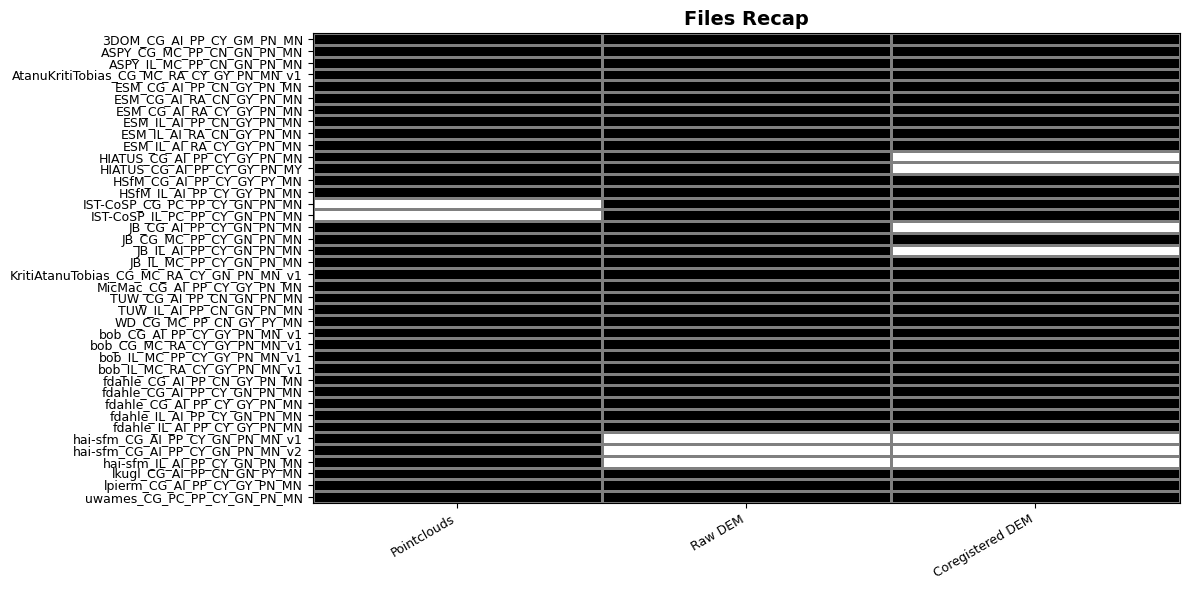

In [11]:
processing_dir = pp.ProcessingDirectory(processing_dir)
processing_dir.submissions_summary()
processing_dir.plot()
